### Make plots from reco dataframe

In [1]:
import pickle
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
with open('/home/atfienberg/freedomDataCopy/public_for_aaron/test_events.pkl', 'rb') as f:
    events = pickle.load(f)

In [3]:
df = pd.read_pickle('./fit_results_8_5_2020.pkl')

In [4]:
df.head()

,evt_idx,free_fit_llh,true_p_llh,retro_p_llh,n_calls,n_iters,x,y,z,time,azimuth,zenith,cascade energy,track energy
0,0,-34.660454,-31.858068,-27.370792,3816,184,-3.471812,-10.545583,-257.928994,9798.435180,5.750355,1.462003,1.622098,8.209995
1,1,-95.957802,-90.545250,-88.510056,4825,239,81.092542,-66.278190,-268.734512,9850.995256,0.166563,1.643600,4.123480,0.130284
2,2,-219.133347,-178.864670,-188.484695,7710,372,40.391612,31.679501,-303.034301,9864.233690,2.203176,2.052683,0.466236,2.258545
3,3,-27.047821,-35.013790,-26.499874,3838,186,-16.154646,-43.669639,-335.015992,10646.420815,3.367391,1.256997,0.137412,2.182596
4,4,-45.614937,-41.375755,-39.881035,7486,358,109.909100,-67.274740,-484.211128,9844.347477,4.633934,1.831585,1.026212,0.280385


In [5]:
# select events where we found an LLH about as good as the true parameters or better
good_df = pd.DataFrame(df[df.free_fit_llh < df.true_p_llh])
print(f'good frac: {len(good_df)/len(df):.2f}')

good frac: 0.94


In [6]:
good_df.head()

,evt_idx,free_fit_llh,true_p_llh,retro_p_llh,n_calls,n_iters,x,y,z,time,azimuth,zenith,cascade energy,track energy
0,0,-34.660454,-31.858068,-27.370792,3816,184,-3.471812,-10.545583,-257.928994,9798.435180,5.750355,1.462003,1.622098,8.209995
1,1,-95.957802,-90.545250,-88.510056,4825,239,81.092542,-66.278190,-268.734512,9850.995256,0.166563,1.643600,4.123480,0.130284
2,2,-219.133347,-178.864670,-188.484695,7710,372,40.391612,31.679501,-303.034301,9864.233690,2.203176,2.052683,0.466236,2.258545
4,4,-45.614937,-41.375755,-39.881035,7486,358,109.909100,-67.274740,-484.211128,9844.347477,4.633934,1.831585,1.026212,0.280385
5,5,-62.997147,-58.590160,-57.401447,4503,233,49.524393,-128.735970,-476.543029,9769.571516,4.735478,1.751872,0.170842,2.475396


In [7]:
par_names = ['x', 'y', 'z', 'time',
             'azimuth', 'zenith', 
             'cascade energy', 'track energy']

# grab true parameters and retro parameters
true_ps = np.empty((len(events), 8), dtype=np.float32)
retro_ps = np.empty_like(true_ps)
spe_ps = np.empty_like(true_ps)
for i, event in enumerate(events):
    true_ps[i, :] = event['params']
    retro_ps[i, :] = event['retro']
    spe_ps[i, :] = event['spefit']

In [8]:
good_retro = retro_ps[good_df.evt_idx]
good_true = true_ps[good_df.evt_idx]
good_spe  = spe_ps[good_df.evt_idx]

In [9]:
retro_zen_diff = good_retro[:, 5] - good_true[:, 5]
spe_zen_diff = good_spe[:, 5] - good_true[:, 5] 
freedom_zen_diff = good_df.zenith - good_true[:, 5]

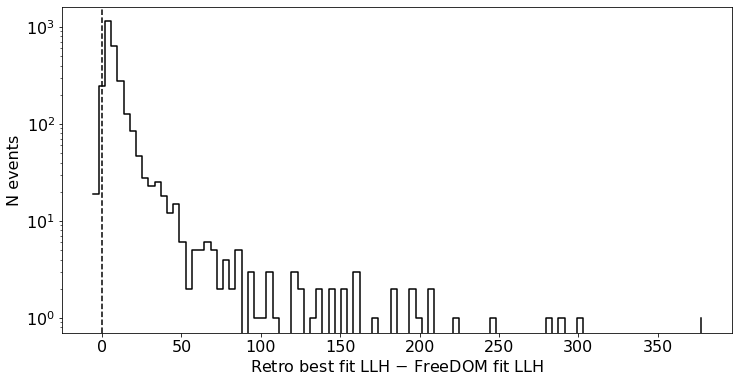

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

llh_diff = good_df.retro_p_llh - good_df.free_fit_llh
bins = np.linspace(llh_diff.min(), llh_diff.max(), 100)
hist, bins = np.histogram(llh_diff, bins)
ax.step(bins[:-1], hist, where='post', color='black')
ax.axvline(0, linestyle='--', color='black')
ax.set_xlabel('Retro best fit LLH $-$ FreeDOM fit LLH', fontsize=16)
ax.set_ylabel('N events', fontsize=16)
ax.tick_params(labelsize=16)
ax.set_yscale('log')

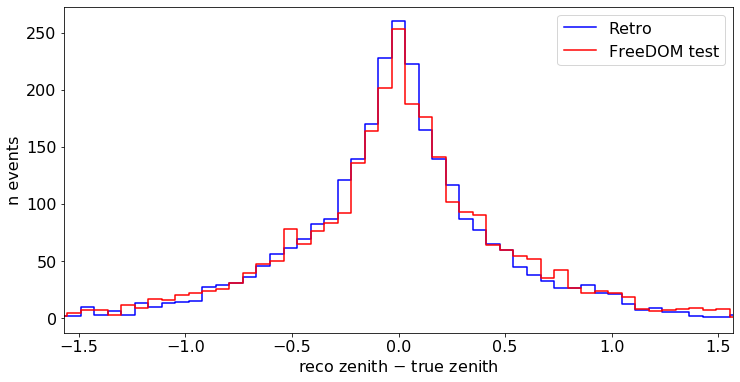

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
bins = np.linspace(-math.pi, math.pi, 100)
retro_hist, bins = np.histogram(retro_zen_diff, bins=bins)
freedom_hist, bins = np.histogram(freedom_zen_diff, bins=bins,)
spe_hist, bins = np.histogram(spe_zen_diff, bins=bins,)

ax.step(bins[:-1], retro_hist, where='post', label='Retro', color='blue')
# ax.step(bins[:-1], spe_hist, where='post', label='SPEFit', color='blue', alpha=0.75)
ax.step(bins[:-1], freedom_hist, where='post', label='FreeDOM test', color='red')

ax.set_xlim(-math.pi/2, math.pi/2)

ax.set_xlabel('reco zenith $-$ true zenith', fontsize=16)
ax.set_ylabel('n events', fontsize=16)
ax.tick_params(labelsize=16)

ax.legend(fontsize=16)

In [12]:
def make_diff_plot(par_name, logy=False):
    ind = par_names.index(par_name)
    
    retro_diff = good_retro[:, ind] - good_true[:, ind]
    spe_diff = good_spe[:, ind] - good_true[:, ind] 
    freedom_diff = good_df[par_name] - good_true[:, ind]
    
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    if not par_name.endswith('energy'):
        bins = np.linspace(freedom_diff.mean() - 2.5*freedom_diff.std(), 
                           freedom_diff.mean() + 2.5*freedom_diff.std(), 100)
    else:
        bins = np.linspace(-500, 100, 100)
    
    retro_hist, bins = np.histogram(retro_diff, bins=bins,)
    freedom_hist, bins = np.histogram(freedom_diff, bins=bins,)
    spe_hist, bins = np.histogram(spe_diff, bins=bins,)
    ax.step(bins[:-1], retro_hist, where='post', label='Retro', color='blue')
    ax.step(bins[:-1], freedom_hist, where='post', label='FreeDOM test', color='red')

    ax.set_xlabel(f' reco {par_name} $-$ true {par_name}', fontsize=16)
    ax.set_ylabel('n events', fontsize=16)
    ax.tick_params(labelsize=16)

    if logy:
        ax.set_yscale('log')
    
    ax.legend(fontsize=16)

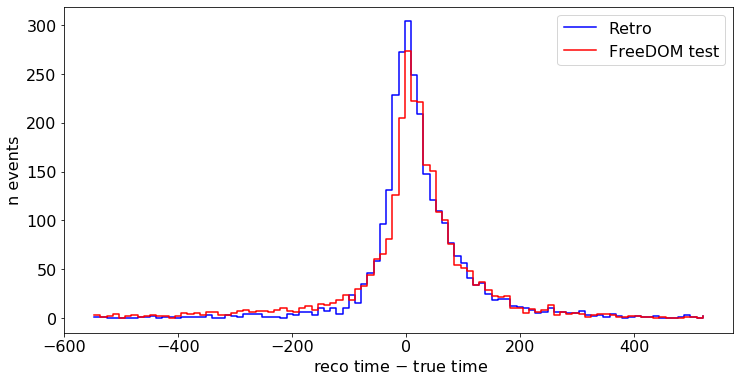

In [13]:
make_diff_plot('time', False)

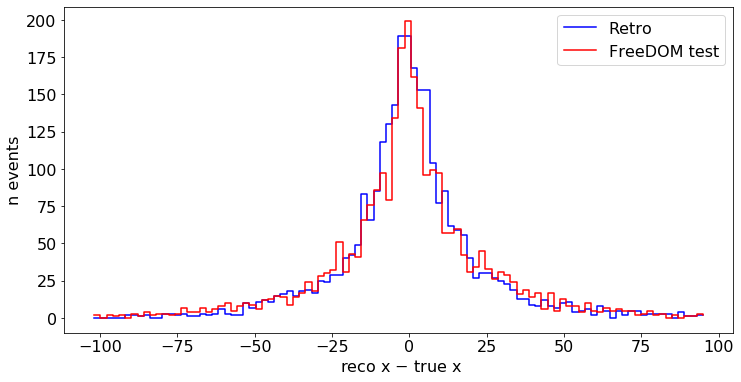

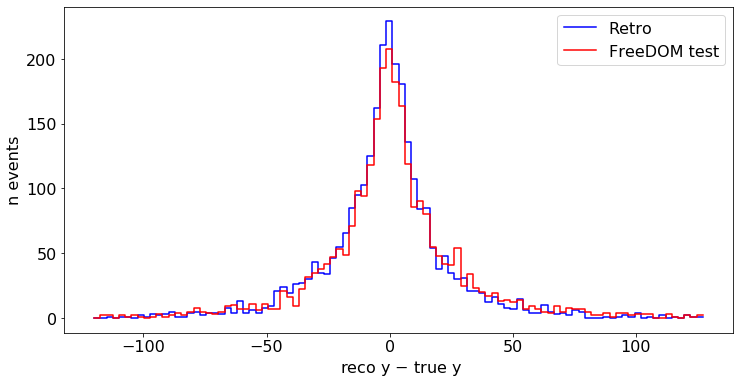

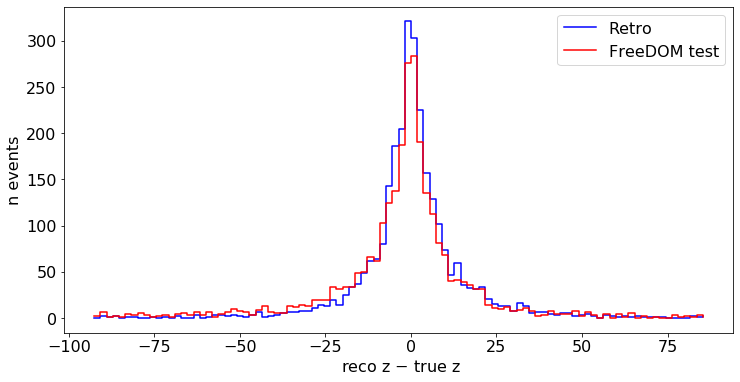

In [14]:
for par in ['x', 'y', 'z']:
    make_diff_plot(par, False)

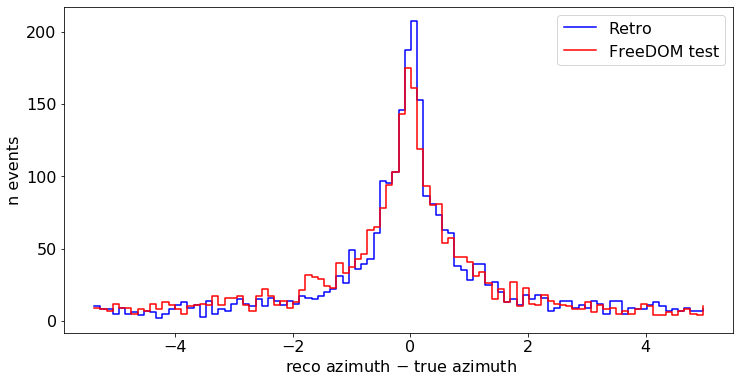

In [15]:
make_diff_plot('azimuth', False)

### energy plots

### 2-d energy reco plot

In [16]:
df["track energy"].max()

99.99792795419535

In [17]:
good_true[:,-2].max()

549.6486

In [18]:
def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    cbar.ax.tick_params(labelsize=12)
    return cbar

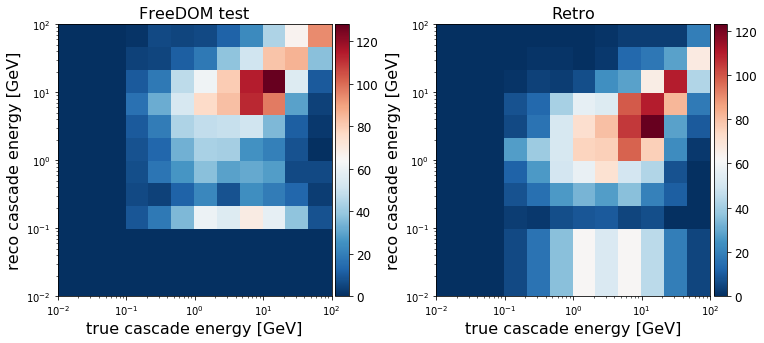

In [19]:
e_range = [0] + list(np.logspace(-1, 2, 10))

fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)

true = good_true[:,-2]

labels = ['FreeDOM test', 'Retro']

for ax, reco, label in zip(ax.flat, (good_df['cascade energy'], good_retro[:, -2]), labels):
    H, x_edge, y_edge = np.histogram2d(true, reco, e_range)

    im = ax.pcolormesh(x_edge, y_edge, H.T, cmap='RdBu_r', rasterized=True)
    colorbar(im)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.01, 100)
    ax.set_ylim(0.01,100)
    ax.set_xlabel('true cascade energy [GeV]', fontsize=16)
    ax.set_ylabel('reco cascade energy [GeV]', fontsize=16)

    ax.set_title(label, fontsize=16)

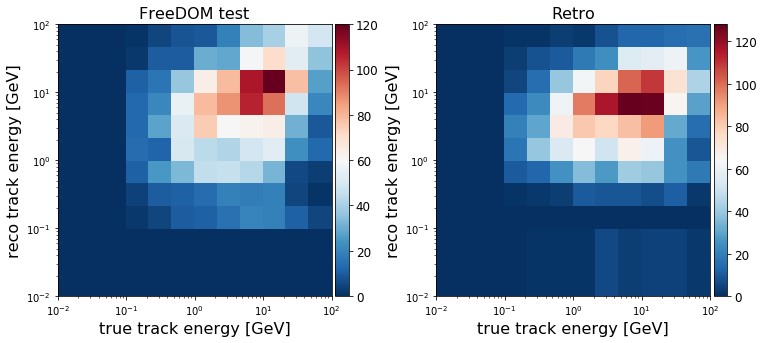

In [20]:
e_range = [0] + list(np.logspace(-1, 2, 10))

fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)

true = good_true[:,-2]

labels = ['FreeDOM test', 'Retro']

for ax, reco, label in zip(ax.flat, (good_df['track energy'], good_retro[:, -1]), labels):
    H, x_edge, y_edge = np.histogram2d(true, reco, e_range)

    im = ax.pcolormesh(x_edge, y_edge, H.T, cmap='RdBu_r', rasterized=True)
    colorbar(im)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.01, 100)
    ax.set_ylim(0.01,100)
    ax.set_xlabel('true track energy [GeV]', fontsize=16)
    ax.set_ylabel('reco track energy [GeV]', fontsize=16)

    ax.set_title(label, fontsize=16)

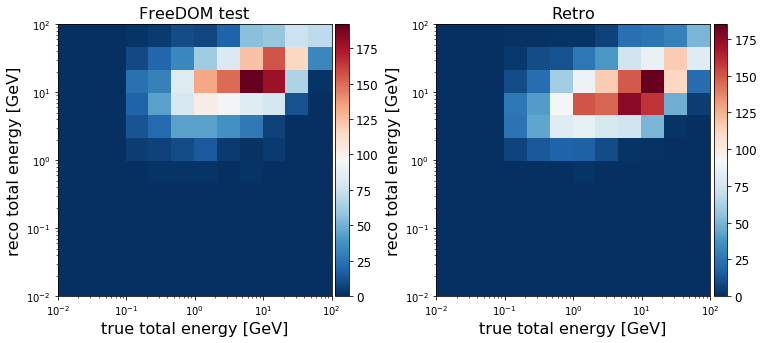

In [21]:
e_range = [0] + list(np.logspace(-1, 2, 10))

fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)

true = good_true[:,-2]

labels = ['FreeDOM test', 'Retro']

for ax, reco, label in zip(ax.flat, (good_df['track energy']+good_df['cascade energy'], good_retro[:, -2:].sum(axis=1)), labels):
    H, x_edge, y_edge = np.histogram2d(true, reco, e_range)

    im = ax.pcolormesh(x_edge, y_edge, H.T, cmap='RdBu_r', rasterized=True)
    colorbar(im)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.01, 100)
    ax.set_ylim(0.01,100)
    ax.set_xlabel('true total energy [GeV]', fontsize=16)
    ax.set_ylabel('reco total energy [GeV]', fontsize=16)

    ax.set_title(label, fontsize=16)

In [22]:
retro_E_sums = good_retro[:, -2:].sum(axis=1)
true_E_sums = good_true[:, -2:].sum(axis=1)
good_df['e_tot'] = good_df['cascade energy'] + good_df['track energy']

In [23]:
retro_E_log_diff = np.log10(retro_E_sums) - np.log10(true_E_sums)
retro_E_rat = (retro_E_sums - true_E_sums)/true_E_sums

freedom_E_log_diff = np.log10(good_df['e_tot']) - np.log10(true_E_sums)
freedom_E_rat = (good_df['e_tot'] - true_E_sums)/true_E_sums

Text(0, 0.5, 'n events')

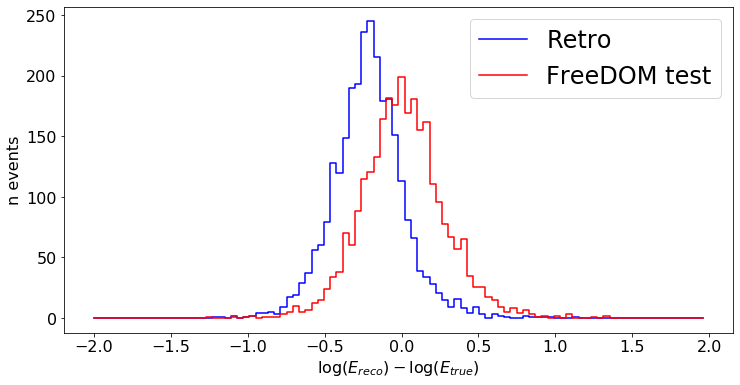

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist_bins = np.linspace(-2, 2, 100)
for var, label, color in zip([retro_E_log_diff, freedom_E_log_diff], ['Retro', 'FreeDOM test'], ['blue', 'red']):
    hist, bins = np.histogram(var, hist_bins)
    
    ax.step(bins[:-1], hist, where='post', label=label, color=color)
    
ax.legend(fontsize=24)
ax.tick_params(labelsize=16)
ax.set_xlabel('$\log(E_{reco}) - \log(E_{true})$', fontsize=16)
ax.set_ylabel('n events', fontsize=16)

Text(0, 0.5, 'n events')

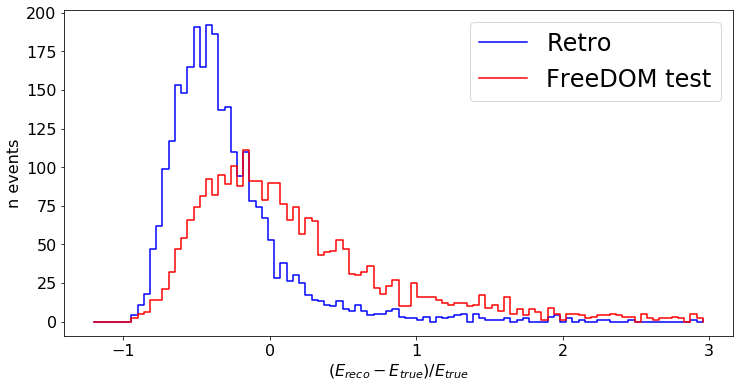

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist_bins = np.linspace(-1.2, 3, 100)
e_rat_hists = []
for var, label, color in zip([retro_E_rat, freedom_E_rat], ['Retro', 'FreeDOM test'], ['blue', 'red']):
    hist, bins = np.histogram(var, hist_bins)
    
    e_rat_hists.append(hist)
    
    ax.step(bins[:-1], hist, where='post', label=label, color=color)
    
ax.legend(fontsize=24)
ax.tick_params(labelsize=16)
ax.set_xlabel('$(E_{reco} - E_{true}) / E_{true}$', fontsize=16)
ax.set_ylabel('n events', fontsize=16)

# Remake the above plot after unbiasing the retro energies (via multiplicative scaling)

In [26]:
bin_centers = 0.5*(bins[:-1] + bins[1:])
retro_E_rat_peak = np.average(bin_centers, weights=e_rat_hists[0])
corrected_retro_E = retro_E_sums / (retro_E_rat_peak+1)

freedom_E_rat_peak = np.average(bin_centers, weights=e_rat_hists[1])
corrected_freedom_E = good_df['e_tot'] / (freedom_E_rat_peak+1)

In [27]:
cor_retro_E_log_diff = np.log10(corrected_retro_E) - np.log10(true_E_sums)
cor_retro_E_rat = (corrected_retro_E - true_E_sums)/true_E_sums

cor_freedom_E_log_diff = np.log10(corrected_freedom_E) - np.log10(true_E_sums)
cor_freedom_E_rat = (corrected_freedom_E - true_E_sums)/true_E_sums

Text(0, 0.5, 'n events')

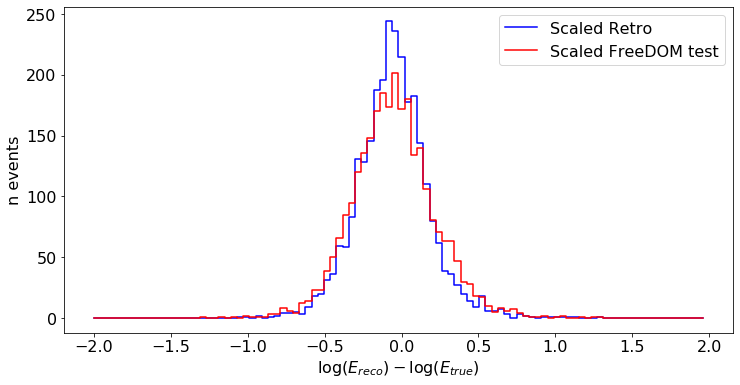

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist_bins = np.linspace(-2, 2, 100)
for var, label, color in zip([cor_retro_E_log_diff, cor_freedom_E_log_diff], ['Scaled Retro', 'Scaled FreeDOM test'], ['blue', 'red']):
    hist, bins = np.histogram(var, hist_bins)
    
    ax.step(bins[:-1], hist, where='post', label=label, color=color)
    
ax.legend(fontsize=16, loc='upper right')
ax.tick_params(labelsize=16)
ax.set_xlabel('$\log(E_{reco}) - \log(E_{true})$', fontsize=16)
ax.set_ylabel('n events', fontsize=16)

Text(0, 0.5, 'n events')

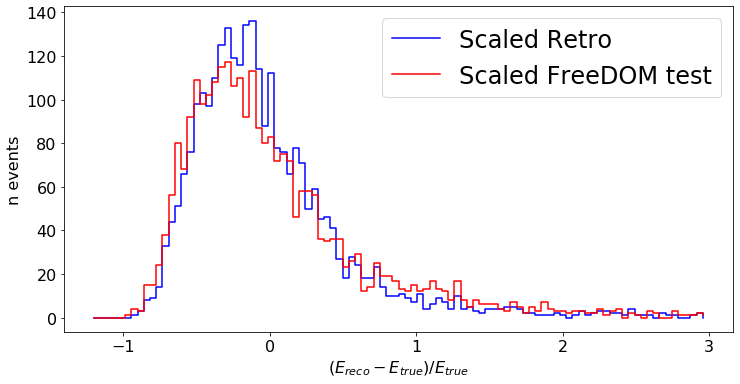

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist_bins = np.linspace(-1.2, 3, 100)
for var, label, color in zip([cor_retro_E_rat, cor_freedom_E_rat], ['Scaled Retro', 'Scaled FreeDOM test'], ['blue', 'red']):
    hist, bins = np.histogram(var, hist_bins)
    
    ax.step(bins[:-1], hist, where='post', label=label, color=color)
    
ax.legend(fontsize=24)
ax.tick_params(labelsize=16)
ax.set_xlabel('$(E_{reco} - E_{true}) / E_{true}$', fontsize=16)
ax.set_ylabel('n events', fontsize=16)